# import Library

In [1]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random
# from mylibrary.fnframework import FNAgent,Environment,Action,Trainer
# from mylibrary.plottrade import PlotTrade
# from mylibrary.maketraindata import MakeTrainData
# import maketraindata
import xgboost as xgb
from sklearn.metrics import accuracy_score  
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
import pickle
import datetime
from sklearn import preprocessing
from sklearn.metrics import r2_score
import copy
import optuna
from keras.callbacks import EarlyStopping

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# path ubu

In [2]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [2]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_doll = '/Users/rince/Desktop/StockPriceData/Stock_index/doll_yen_bid.csv'
path_gold = '/Users/rince/Desktop/StockPriceData/Stock_index/gold_chusin.csv'

# path win

In [2]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'

# funcs

In [4]:
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic', 'n_estimators':16,'use_label_encoder':False,
                 'max_depth':4}
    
    param_def = {'objective':'binary:logistic','use_label_encoder':False}
    xgb_model = xgb.XGBClassifier(**param_dist)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

def for_xgb_data(path_tpx, path_daw):
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    return df_tmp

def make_x_train(path_tpx, path_daw):
    df_tpx  = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx['close']],axis = 1,join='inner').astype(float)

    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp['close'].iloc[1:]
    return x_train, price_chart

def make_x_train2(state_, chart_, path_tpx, path_daw):
    df_state = pd.DataFrame(state_)
    df_state['day'] = chart_.index
    df_state.reset_index(inplace=True)
    df_state.set_index('day',inplace=True)
    df_state.drop('index',axis=1,inplace=True)
    
    x_train, _ = make_x_train(path_tpx, path_daw)
    x_train = pd.concat([x_train,df_state],axis = 1,join='inner').astype(float)
    
    return x_train, chart_

def predict_tomorrow(lq,folder_name):
    path_ = '/Users/rince/Desktop/StockPriceData/%s/*.csv' % folder_name
    file = glob.glob(path_)
    path_tpx = sorted(file)[-1]
    path_ = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
    file = glob.glob(path_)
    path_daw = sorted(file)[-1]
    lq.predict_tomorrow(path_tpx,path_daw)
    
def plot(g,label='x'):
#     type(g) = pd.DataFrame
    plt.subplots(figsize=(10, 6))
    plt.fill_between(g.index,y1 = g['ma'] - g['std'],y2=g['ma']+g['std'],alpha=0.3)
    plt.plot(g.index,g['ma'])
    plt.xlabel(label)
    plt.ylabel('reward')
    plt.grid(True)
    
def make_plot_data(reward_log, ma=5):
#     type(reward_log)==list

    length = len(reward_log)
    reward_log = np.array(reward_log)
    reward_dict = {}
    if ma%2==0:
        print("ma must be odd number.")
        return 
    
    
    sride = ma//2
    try:
        for i in range(sride,length-sride):
            reward_dict[i] = {'reward':reward_log[i],'ma':reward_log[i-sride:i+sride+1].mean(),
                             'std':reward_log[i-sride:i+sride+1].std()}
    except:
        print("Error.")
    
    return pd.DataFrame(reward_dict).T
     
def easy_plot(df,xlabel='episode',ylabel='reward'):
    plt.subplots(figsize=(10, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.plot(df)
    plt.show()
    
def make_df_con(path_tpx,path_daw):
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    return df_tmp

def grid_search(x_train,y_train,x_test,y_test):
    trains = xgb.DMatrix(x_train.astype(float), label=y_train)
    tests = xgb.DMatrix(x_test.astype(float), label=y_test)

    base_params = {
        'booster': 'gbtree',
        'objective':'binary:logistic',
        'eval_metric': 'rmse',
        'random_state':100,
        'use_label_encoder':False
    }

    watchlist = [(trains, 'train'), (tests, 'eval')]
    tmp_params = copy.deepcopy(base_params)
    
#     インナー関数
    def optimizer(trial):
        eta = trial.suggest_uniform('eta', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        __lambda = trial.suggest_uniform('lambda', 0.7, 2)
        n_estimators = trial.suggest_int('n_estimators', 3, 20)
        learning_rate = trial.suggest_uniform('lambda', 0.01, 1)
        reg_alpha = trial.suggest_uniform('reg_alpha', 0.01, 1)
        reg_lambda = trial.suggest_uniform('reg_lambda', 0.01, 1)
        importance_type = trial.suggest_categorical('importance_type',
                                                    ['gain', 'weight', 'cover','total_gain','total_cover'])

        tmp_params['eta'] = eta
        tmp_params['max_depth'] = max_depth
        tmp_params['lambda'] = __lambda
        tmp_params['n_estimators'] = n_estimators
        tmp_params['learning_rate'] = learning_rate
        tmp_params['reg_alpha'] = reg_alpha
        tmp_params['reg_lambda'] = reg_lambda
        tmp_params['importance_type'] = importance_type
        model = xgb.train(tmp_params, trains, num_boost_round=50)
        predicts = model.predict(tests)
        r2 = r2_score(y_test, predicts)
        print(f'#{trial.number}, Result: {r2}, {trial.params}')
        return r2
    
    study = optuna.create_study(direction='maximize')
    study.optimize(optimizer, n_trials=500)
    print(study.best_params)
    print(study.best_value)

def sigmoid(x):
    return 1 / 1 + np.exp(-x)  

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def return_latest_data_path(folder_name):
    path_ = '/Users/rince/Desktop/StockPriceData/%s/*.csv' % folder_name
    file = glob.glob(path_)
    path_tpx = sorted(file)[-1]
    path_ = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
    file = glob.glob(path_)
    path_daw = sorted(file)[-1]
    return path_tpx, path_daw

def load_csv(load_path):
    df = pd.read_csv(load_path, index_col=0)
    return df

# classes

In [72]:
Experience = namedtuple("Experience", ["s","a","r","n_s","n_a","d"])

class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)
    
class PlotTrade():
    
    
    def __init__(self, df_chart,label=''):
        self.df_chart = df_chart
        plt.clf()
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.plot(self.df_chart,label=label)
        plt.legend()
        
    def add_span(self, start_time,end_time):
        self.ax.axvspan(start_time, end_time, color="gray", alpha=0.3)
        
    
    def add_plot(self, df_plot,label=''):
        self.ax.plot(df_plot,label=label)
        plt.legend()
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()
         
class ValidatePlot(PlotTrade):
    
    
    def __init__(self, df_chart, is_validate=False):
        pass
        
    def add_span(self, start_time,end_time):
        pass
        
    
    def add_plot(self, df_plot):
        pass
        
        
    def show(self):
        pass
    
class TechnicalSimulation():
    
    
    def __init__(self,ma_short=5, ma_long=25, hold_day=5, year=2021):
        self.ma_short = ma_short
        self.ma_long = ma_long
        self.hold_day = hold_day
        self.year = year
        
        
    def process(self,df):
        df_process = df.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process[df_process.index.year==self.year]
    
    
    def is_buyable(self, short_line, long_line, index_):
#         1=<index<=len-1 仮定
        long_is_upper = long_line.iloc[index_-1]>=short_line.iloc[index_-1]
        long_is_lower = long_line.iloc[index_+1]<=short_line.iloc[index_+1]
        buyable = long_is_upper and long_is_lower
        return buyable
    
    
    def is_sellable(self, short_line, long_line, index_):
        long_is_lower = long_line.iloc[index_-1]<=short_line.iloc[index_-1]
        long_is_upper = long_line.iloc[index_+1]>=short_line.iloc[index_+1]
        sellable = long_is_upper and long_is_lower
        return sellable
        
        
    def simulate(self,df,is_validate=False):
        df_process = self.process(df)
        is_bought = False
        hold_count_day = 0
        index_buy = 0
        index_sell = 0
        pl = PlotTrade(df_process['close'],label='close')
        pl.add_plot(df_process['ma_short'],label='ma_5')
        pl.add_plot(df_process['ma_long'],label='ma_25')   
        prf = 0
        start_time = 0
        end_time = 0
        short_line = df_process['ma_short']
        long_line  = df_process['ma_long']
        trade_count = 0
        for_plot1=[]
        for_plot2=[]
        self.pr_log = pd.DataFrame()
        self.pr_log.index = df.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0
        
        
        for i in range(5,len(df_process)-1):
            
            
            total_eval_price = prf
            self.pr_log['reward'].loc[df_process.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
            if not is_bought:
                
                if self.is_buyable(short_line,long_line,i):
                    index_buy = df_process['close'].iloc[i]
                    is_bought = True
                    start_time = df_process.index[i]
                    hold_count_day = 0
                else:
                    continue
            
            
            else:
                
                if self.is_sellable(short_line,long_line,i) or hold_count_day==self.hold_day:
                    index_cell = df_process['close'].iloc[i]
                    end_time = df_process.index[i]
                    prf += index_cell - index_buy
                    total_eval_price = prf
                    self.pr_log['reward'].loc[df_process.index[i]] = prf 
                    self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
                    trade_count+=1
                    is_bought = False
                    hold_count_day = 0
                    pl.add_span(start_time,end_time)
                else:
                    hold_count_day+=1
                    eval_price = df_process['close'].iloc[i] - index_buy
                    total_eval_price += eval_price
                    self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
                    
        
        if is_bought and hold_count_day>0:
            end_time = df_process['close'].index[-1]
            pl.add_span(start_time,end_time)
            eval_price = df_process['close'].iloc[-1] - index_buy
            total_eval_price += eval_price
            self.pr_log['eval_reward'].loc[df_process.index[-1]] = total_eval_price
        
    
        if not is_validate:        
            print("Total profit {}.".format(prf))
            print("Trade count",trade_count)
            pl.show()    
        
        
        
    def return_profit_rate(self, path_tpx,wallet=2500):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        self.simulate(df_tpx,is_validate=True)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log
    
class XGBSimulation():
    
    
    def __init__(self, xgb_model, alpha=0.70):
        self.xgb_model = xgb_model
        self.alpha = alpha
        self.acc_df = None
        self.y_check = None
        self.ma_long = 0
        self.ma_short = 0
        
        
    
    def make_df_con(self, path_tpx,path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_tmp
    
    
    def make_check_data(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con,test_rate=1.0)
        x_check, y_check, x_dummy, y_dummy = mk.make_data()
        self.ma_short = mk.ma_short
        self.ma_long = mk.ma_long
        return x_check, y_check
    
    
    def eval_proba(self, x_test, y_test):
        predict_proba = self.xgb_model.predict_proba(x_test.astype(float))
        df = pd.DataFrame(columns = ['score','Up precision','Down precision','Up recall','Down recall','up_num','down_num'])
        j=0
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        
        
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > self.alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        
        try:
            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            up_num = TU+FD
            down_num = TD+FU
            down_num
            col_list = [score,prec_u,prec_d,recall_u,recall_d,up_num,down_num]
            df.loc[j] = col_list
            j+=1
            return df
        except:
            print("division by zero")
            return None
        
    
    def return_df_con(self,path_tpx,path_daw):
        df_con =  self.make_df_con(path_tpx,path_daw)
        return df_con
    
    
    def return_grad(self, df, index, gamma=0, delta=0,):
        grad_ma_short = df['ma_short'].iloc[index+1] - df['ma_short'].iloc[index]
        grad_ma_long  = df['ma_long'].iloc[index+1] - df['ma_long'].iloc[index]
        strategy = ''
        
        if grad_ma_long >= gamma:
            strategy = 'normal'
        elif grad_ma_long < delta:
            strategy = 'reverse'
        else:
            print("No such threshold")
        return strategy
        
    
    def return_split_df(self,df,start_year=2021,end_year=2021,start_month=1,end_month=12):
        df = df[df.index.year>=start_year]
        if start_year <= end_year:
            df = df[df.index.year<=end_year]
        if len(set(df.index.year))==1:
            df = df[df.index.month>=start_month]
            df = df[df.index.month<=end_month]
        else:
            df_tmp = df[df.index.year==start_year]
            last_year_index = df_tmp[df_tmp.index.month==start_month].index[0]
#             new_year_index = df[df.index.month==end_year].index[-1]
            df = df.loc[last_year_index:]
        return df
    
    
#*    日付変更できるように変更
    def simulate(self, path_tpx, path_daw, is_validate=False,strategy='normal',is_online=False,start_year=2021,end_year=2021,start_month=1,end_month=12,ma_short=5,ma_long=25,is_variable_strategy=False):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)
        y_ = pd.DataFrame(y_check)
        y_.index = x_check.index
        x_check = self.return_split_df(x_check,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        y_ = self.return_split_df(y_,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        y_check = y_.values.reshape(-1).tolist()
        length = len(x_check)
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        trade_count = 0
        df_con = self.return_df_con(path_tpx,path_daw)
        df_con['ma_short'] = df_con['close'].rolling(self.ma_short).mean()
        df_con['ma_long']  = df_con['close'].rolling(self.ma_long).mean()
        df_con = df_con.iloc[self.ma_long:]
        df_con = self.return_split_df(df_con,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        pl = PlotTrade(df_con['close'],label='close')
        pl.add_plot(df_con['ma_short'],label='ma_short')
        pl.add_plot(df_con['ma_long'],label='ma_long')
        prf_list = []
        self.pr_log = pd.DataFrame()
        self.pr_log.index = x_check.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0
#*      オンライン学習用の学習データ   
        x_tmp = x_check.copy()
        y_tmp = y_.copy()
        current_date = x_tmp.index[0]
        acc_df = pd.DataFrame()
        acc_df.index = x_tmp.index
        acc_df['pred'] = [-1] * len(acc_df)
#* 判定不能は -1, 騰貴予測は 1, 下落予測は 0
        
        
        for i in range(length-1):
            
            
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
#             label==0 -> down
#             label==1 -> up
#*          オンライン学習
            tmp_date = x_tmp.index[i]
            if current_date.month!=tmp_date.month and is_online:
#             x_ = x_tmp.loc[:x_tmp.index]
                x_ = x_tmp[current_date<=x_tmp.index]
                x_ = x_[x_.index<tmp_date]
                y_ = y_tmp[current_date<=y_tmp.index]
                y_ = y_[y_.index<tmp_date]
#                 param_dist = {'objective':'binary:logistic', 'n_estimators':16,'use_label_encoder':False,
#                  'max_depth':4}
#                 tmp_xgb = xgb.XGBClassifier(**param_dist)
                self.xgb_model = self.xgb_model.fit(x_,y_)
                predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
                current_date = tmp_date
            
            if prob > self.alpha:
                if label == 0:
                    acc_df.iloc[i] = 0
                else: #l able == 1 
                    acc_df.iloc[i] = 1
            
            
            if is_variable_strategy:
                strategy = self.return_grad(df_con, index=i,gamma=0, delta=0)
            
                
            if strategy=='reverse':
            
                if not is_bought:
    #                 下がって買い
                    if label==0 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 上がって売り
                    if label==1 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
                        
                        
            elif strategy=='normal':
                
                if not is_bought:
    #                 上がって買い
                    if label==1 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 下がって売り
                    if label==0 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            else:
                print("No such strategy.")
                return 
                  
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        self.acc_df = acc_df
        self.y_check = y_check
            
        
        try:
            if not is_validate:
                print("Total profit :{}".format(prf))
                print("Trade count  :{}".format(trade_count))
                print("Max profit   :{}".format(prf_array.max()))
                print("Min profit   :{}".format(prf_array.min()))
                print("Mean profit  :{}".format(prf_array.mean()))
                if not is_online:
                    df = self.eval_proba(x_check,y_check)
                else:
                    df = self.calc_acc(acc_df, y_check)
                print(df)
                print("")
                pl.show()
        except:
            print("no trade")
            
    
    def simulate_sm(self, path_tpx, path_daw, sm, is_validate=False,is_online=False,start_year=2021,end_year=2021,start_month=1,end_month=12,ma_short=5,ma_long=25,theta=0.0001):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)
        y_ = pd.DataFrame(y_check)
        y_.index = x_check.index
        x_check = self.return_split_df(x_check,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        y_ = self.return_split_df(y_,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        y_check = y_.values.reshape(-1).tolist()
        length = len(x_check)
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        trade_count = 0
        df_con = self.return_df_con(path_tpx,path_daw)
        df_con['ma_short'] = df_con['close'].rolling(self.ma_short).mean()
        df_con['ma_long']  = df_con['close'].rolling(self.ma_long).mean()
        df_con = df_con.iloc[self.ma_long:-1]
        df_con = self.return_split_df(df_con,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        pl = PlotTrade(df_con['close'],label='close')
        pl.add_plot(df_con['ma_short'],label='ma_short')
        pl.add_plot(df_con['ma_long'],label='ma_long')
        prf_list = []
        self.pr_log = pd.DataFrame()
        self.pr_log.index = x_check.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0
#*      オンライン学習用の学習データ   
        x_tmp = x_check.copy()
        y_tmp = y_.copy()
        current_date = x_tmp.index[0]
        acc_df = pd.DataFrame()
        acc_df.index = x_tmp.index
        acc_df['pred'] = [-1] * len(acc_df)
        x_sm, y_sm = sm.make_train_data(path_tpx, path_daw,year=start_year,theta=theta)
        x_sm = self.return_split_df(x_sm,start_year=start_year,end_year=end_year,start_month=start_month,end_month=end_month)
        buy_sign = sm.model.predict(x_sm)
#* 判定不能は -1, 騰貴予測は 1, 下落予測は 0
        
        
        for i in range(length-1):
            
            
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
#             label==0 -> down
#             label==1 -> up
#*          オンライン学習
            tmp_date = x_tmp.index[i]
            if current_date.month!=tmp_date.month and is_online:
#             x_ = x_tmp.loc[:x_tmp.index]
                x_ = x_tmp[current_date<=x_tmp.index]
                x_ = x_[x_.index<tmp_date]
                y_ = y_tmp[current_date<=y_tmp.index]
                y_ = y_[y_.index<tmp_date]
#                 param_dist = {'objective':'binary:logistic', 'n_estimators':16,'use_label_encoder':False,
#                  'max_depth':4}
#                 tmp_xgb = xgb.XGBClassifier(**param_dist)
                self.xgb_model = self.xgb_model.fit(x_,y_)
                predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
                current_date = tmp_date
            
            if prob > self.alpha:
                if label == 0:
                    acc_df.iloc[i] = 0
                else: #l able == 1 
                    acc_df.iloc[i] = 1
                    
#                     「買い」 サインの時
            if buy_sign[i]==1:
                if prob >0.5 :
                    strategy='normal'
                else:
                    strategy='reverse'
            else:
                strategy=None
                

            if strategy=='reverse' and buy_sign[i]==1:
            
                if not is_bought:
    #                 下がって買い
                    if label==0 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 上がって売り
                    if label==1 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
                        
                        
            elif strategy=='normal' and buy_sign[i]==1:
                
                if not is_bought:
    #                 上がって買い
                    if label==1 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 下がって売り
                    if label==0 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            
            
            elif strategy==None:
                continue
                
        
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        self.acc_df = acc_df
        self.y_check = y_check
            
        
        try:
            if not is_validate:
                print("Total profit :{}".format(prf))
                print("Trade count  :{}".format(trade_count))
                print("Max profit   :{}".format(prf_array.max()))
                print("Min profit   :{}".format(prf_array.min()))
                print("Mean profit  :{}".format(prf_array.mean()))
                if not is_online:
                    df = self.eval_proba(x_check,y_check)
                else:
                    df = self.calc_acc(acc_df, y_check)
                print(df)
                print("")
                pl.show()
        except:
            print("no trade")
            
    
    def calc_acc(self, acc_df, y_check):
        df = pd.DataFrame(columns = ['score','Up precision','Down precision','Up recall','Down recall','up_num','down_num'])
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        
        
        for i in range(len(acc_df)):
            
            label = acc_df['pred'].iloc[i]
            if y_check[i]==label:
                if label==0:
                    acc_dict['TD'] += 1
                else:#label = 1 : UP
                    acc_dict['TU'] += 1
            else:
                if label==0:
                    acc_dict['FD'] += 1
                else:
                    acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        
        try:
            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            up_num = TU+FD
            down_num = TD+FU
            col_list = [score,prec_u,prec_d,recall_u,recall_d,up_num,down_num]
            df.loc[0] = col_list
            return df
        except:
            print("division by zero")
            return None
        
      
    def return_accuracy(self, path_tpx,path_daw,strategy='normal',is_online=False,start_year=2021,start_month=1):
        self.simulate(path_tpx,path_daw,is_validate=True,strategy=strategy,is_online=is_online)
        y_check = pd.DataFrame(self.y_check)
        y_check.index = self.acc_df.index
        acc_df = self.acc_df.copy()
        acc_df = acc_df[acc_df.index.year==start_year]
        acc_df = acc_df[acc_df.index.month>=start_month]
        y_check = y_check[y_check.index.year==start_year]
        y_check = y_check[y_check.index.month>=start_month]
        df = self.calc_acc(acc_df,y_check.values)
        return df
    
        
    def show_result(self, path_tpx,path_daw,strategy='normal'):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)  
        self.simulate(x_check,y_check,strategy)
        
        
    def return_profit_rate(self, path_tpx,path_daw,wallet=2500,strategy='normal',is_online=False,start_year=2021,start_month=1):
        self.simulate(path_tpx,path_daw, is_validate=True,strategy=strategy,is_online=is_online,start_year=start_year,start_month=start_month)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log

class MakeTrainData():
    
    
    def __init__(self, df_con, test_rate=0.9, questions_index = [], is_bit_search=False,is_category=True,ma_short=5,ma_long=25):
        self.df_con = df_con
        self.test_rate = test_rate
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        df_process['std_short'] = df_process['close'].rolling(self.ma_short).std()
        df_process['std_long']  = df_process['close'].rolling(self.ma_long).std()
        df_process['ema_short'] = df_process['close'].ewm(span=self.ma_short, adjust=False).mean()
        df_process['ema_long'] = df_process['close'].ewm(span=self.ma_long, adjust=False).mean()
        df_process['macd'] = df_process['ema_short'] - df_process['ema_long']
        df_process['macd_signal'] = df_process['macd'].ewm(span=self.ma_long, adjust=False).mean()
        return df_process
                
    
    def make_question_column(self):
        column_questions = [
                'dawp_5',
                'dawp_4',
                'dawp_3',
                'dawp_2',
                'dawp_1',
                'dawp_0',
                'nikkeip_5',
                'nikkeip_4',
                'nikkeip_3',
                'nikkeip_2',
                'nikkeip_1',
                'nikkeip_0',
                'diff_rate',
                'nikkei_volumep',
                'std_s_5',
                'std_s_4',
                'std_s_3',
                'std_s_2',
                'std_s_1',
                'std_s_0',
                'std_l_5', 
                'std_l_4', 
                'std_l_3', 
                'std_l_2', 
                'std_l_1',
                'std_l_0', 
                'vec_s_5', 
                'vec_s_4',
                'vec_s_3', 
                'vec_s_2',
                'vec_s_1', 
                'vec_l_5', 
                'vec_l_4', 
                'vec_l_3', 
                'vec_l_2', 
                'vec_l_1',
                'emavec_s_5' , 
                'emavec_s_4' ,
                'emavec_s_3' , 
                'emavec_s_2' ,
                'emavec_s_1' , 
                'emavec_l_5' , 
                'emavec_l_4' , 
                'emavec_l_3' , 
                'emavec_l_2' , 
                'emavec_l_1',
                'macd',
                'macd_signal',
                'coef_short',
                'coef_long'
            ]
        return column_questions
        
        
    def make_data(self,is_check=False):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        end_point = -1
        
        
        if is_check:
            end_point = len(self.df_con)
        else:
            end_point = len(self.df_con)-1
            
            
        for i in range(self.ma_long+day_sride,end_point):
            dawp_5 = self.df_con['dopen'].iloc[i-5]
            dawp_4 = self.df_con['dopen'].iloc[i-4]
            dawp_3 = self.df_con['dopen'].iloc[i-3]
            dawp_2 = self.df_con['dopen'].iloc[i-2]
            dawp_1 = self.df_con['dopen'].iloc[i-1]
            dawp_0 = self.df_con['dopen'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-5]
            nikkeip_4 = df_tpx_p.iloc[i-4]
            nikkeip_3 = df_tpx_p.iloc[i-3]
            nikkeip_2 = df_tpx_p.iloc[i-2]
            nikkeip_1 = df_tpx_p.iloc[i-1]
            nikkeip_0 = df_tpx_p.iloc[i]
#             *_0 は最も最近のデータ, つまり昨日のデータ
            
            diff_high_low = self.df_con['high'].iloc[i] -self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])/self.df_con['volume'].iloc[i-1]
            
            df_ma = self.add_ma()
            std_s_5 = df_ma['std_short'].iloc[i-5]
            std_s_4 = df_ma['std_short'].iloc[i-4]
            std_s_3 = df_ma['std_short'].iloc[i-3]
            std_s_2 = df_ma['std_short'].iloc[i-2]
            std_s_1 = df_ma['std_short'].iloc[i-1]
            std_s_0 = df_ma['std_short'].iloc[i]
            std_l_5 = df_ma['std_long'].iloc[i-5]
            std_l_4 = df_ma['std_long'].iloc[i-4]
            std_l_3 = df_ma['std_long'].iloc[i-3]
            std_l_2 = df_ma['std_long'].iloc[i-2]
            std_l_1 = df_ma['std_long'].iloc[i-1]
            std_l_0 = df_ma['std_long'].iloc[i]
            
            vec_s_5 = (df_ma['ma_short'].iloc[i] - df_ma['ma_short'].iloc[i-5])/5
            vec_s_4 = (df_ma['ma_short'].iloc[i] - df_ma['ma_short'].iloc[i-4])/4
            vec_s_3 = (df_ma['ma_short'].iloc[i] - df_ma['ma_short'].iloc[i-3])/3
            vec_s_2 = (df_ma['ma_short'].iloc[i] - df_ma['ma_short'].iloc[i-2])/2
            vec_s_1 = (df_ma['ma_short'].iloc[i] - df_ma['ma_short'].iloc[i-1])/1
            vec_l_5 = (df_ma['ma_long'].iloc[i] - df_ma['ma_long'].iloc[i-5])/5
            vec_l_4 = (df_ma['ma_long'].iloc[i] - df_ma['ma_long'].iloc[i-4])/4
            vec_l_3 = (df_ma['ma_long'].iloc[i] - df_ma['ma_long'].iloc[i-3])/3
            vec_l_2 = (df_ma['ma_long'].iloc[i] - df_ma['ma_long'].iloc[i-2])/2
            vec_l_1 = (df_ma['ma_long'].iloc[i] - df_ma['ma_long'].iloc[i-1])/1
#             ema のベクトル
            emavec_s_5 = (df_ma['ema_short'].iloc[i] - df_ma['ema_short'].iloc[i-5])/5
            emavec_s_4 = (df_ma['ema_short'].iloc[i] - df_ma['ema_short'].iloc[i-4])/4
            emavec_s_3 = (df_ma['ema_short'].iloc[i] - df_ma['ema_short'].iloc[i-3])/3
            emavec_s_2 = (df_ma['ema_short'].iloc[i] - df_ma['ema_short'].iloc[i-2])/2
            emavec_s_1 = (df_ma['ema_short'].iloc[i] - df_ma['ema_short'].iloc[i-1])/1
            emavec_l_5 = (df_ma['ema_long'].iloc[i] - df_ma['ema_long'].iloc[i-5])/5
            emavec_l_4 = (df_ma['ema_long'].iloc[i] - df_ma['ema_long'].iloc[i-4])/4
            emavec_l_3 = (df_ma['ema_long'].iloc[i] - df_ma['ema_long'].iloc[i-3])/3
            emavec_l_2 = (df_ma['ema_long'].iloc[i] - df_ma['ema_long'].iloc[i-2])/2
            emavec_l_1 = (df_ma['ema_long'].iloc[i] - df_ma['ema_long'].iloc[i-1])/1

            macd = df_ma['macd'].iloc[i]
            macd_signal = df_ma['macd_signal'].iloc[i]
#           daw, tpxの終値相関係数
# とりあえず直近25日間の相関係数とする
            x = self.df_con['dclose'].iloc[i-self.ma_short+1:i+1].values
            y = self.df_con['close'].iloc[i-self.ma_short+1:i+1].values
            coef_short = np.corrcoef(x,y)[0,1]
            x = self.df_con['dclose'].iloc[i-self.ma_long+1:i+1].values
            y = self.df_con['close'].iloc[i-self.ma_long+1:i+1].values
            coef_long = np.corrcoef(x,y)[0,1]

            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                dawp_0,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                nikkeip_0,
                diff_rate,
                nikkei_volumep,
                std_s_5 ,
                std_s_4,
                std_s_3 ,
                std_s_2 ,
                std_s_1,
                std_s_0 ,
                std_l_5 , 
                std_l_4 , 
                std_l_3 , 
                std_l_2 , 
                std_l_1 ,
                std_l_0 , 
                vec_s_5 , 
                vec_s_4 ,
                vec_s_3 , 
                vec_s_2 ,
                vec_s_1 , 
                vec_l_5 , 
                vec_l_4 , 
                vec_l_3 , 
                vec_l_2 , 
                vec_l_1,            
                emavec_s_5 , 
                emavec_s_4 ,
                emavec_s_3 , 
                emavec_s_2 ,
                emavec_s_1 , 
                emavec_l_5 , 
                emavec_l_4 , 
                emavec_l_3 , 
                emavec_l_2 , 
                emavec_l_1,
                macd,
                macd_signal,
                coef_short,
                coef_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            if not is_check:
                tommorow_close = self.df_con['close'].iloc[i+1]
                today_close    = self.df_con['close'].iloc[i]
                if tommorow_close>today_close:
                    df_ans.append(up)
                else:
                    df_ans.append(down)
        
        x_check = dfx
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        if not is_check:
            y_train = df_ans[:int(len(dfx)*self.test_rate)]
            y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        if not is_check:
            return x_train, y_train, x_test, y_test
        else:
            chart_ = self.df_con.loc[x_check.index]
            return x_check,chart_
        
class MakeTrainData2(MakeTrainData):
    

                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        df_process['std_short'] = df_process['close'].rolling(self.ma_short).std()
        df_process['std_long']  = df_process['close'].rolling(self.ma_long).std()
        df_process['ema_short'] = df_process['close'].ewm(span=self.ma_short, adjust=False).mean()
        df_process['ema_long'] = df_process['close'].ewm(span=self.ma_long, adjust=False).mean()
        df_process['macd'] = df_process['ema_short'] - df_process['ema_long']
        df_process['macd_signal'] = df_process['macd'].ewm(span=self.ma_long, adjust=False).mean()
        return df_process
                
   
        
    def make_data(self,is_check=False):
        x_ = pd.DataFrame()
        y_ = pd.DataFrame()
        x_.index = self.df_con.index
        y_.index = self.df_con.index
        df_con = self.df_con.copy()
        df_ma = self.add_ma()
        
        dawp_5 = df_con['dopen'].tolist()
        dawp_4 = df_con['dopen'].tolist()
        dawp_3 = df_con['dopen'].tolist()
        dawp_2 = df_con['dopen'].tolist()
        dawp_1 = df_con['dopen'].tolist()
        dawp_0 = df_con['dopen'].tolist()
        nikkeip_5 = df_con['pclose'].tolist()
        nikkeip_4 = df_con['pclose'].tolist()
        nikkeip_3 = df_con['pclose'].tolist()
        nikkeip_2 = df_con['pclose'].tolist()
        nikkeip_1 = df_con['pclose'].tolist()
        nikkeip_0 = df_con['pclose'].tolist()
        high_low = (df_con['high']-df_con['low'])/df_con['close']
        nikkei_volumep = df_con['volume'].pct_change()
        std_s_5 = df_ma['std_short'].tolist()
        std_s_4 = df_ma['std_short'].tolist()
        std_s_3 = df_ma['std_short'].tolist()
        std_s_2 = df_ma['std_short'].tolist()
        std_s_1 = df_ma['std_short'].tolist()
        std_s_0 = df_ma['std_short'].tolist()
        std_l_5 = df_ma['std_long'].tolist()
        std_l_4 = df_ma['std_long'].tolist()
        std_l_3 = df_ma['std_long'].tolist()
        std_l_2 = df_ma['std_long'].tolist()
        std_l_1 = df_ma['std_long'].tolist()
        std_l_0 = df_ma['std_long'].tolist()

        vec_s_5 = (df_ma['ma_short'].diff(5)/5).tolist() 
        vec_s_4 = (df_ma['ma_short'].diff(4)/4).tolist() 
        vec_s_3 = (df_ma['ma_short'].diff(3)/3).tolist() 
        vec_s_2 = (df_ma['ma_short'].diff(2)/2).tolist() 
        vec_s_1 = df_ma['ma_short'].diff(1).tolist() 
    
        vec_l_5 = (df_ma['ma_long'].diff(5)/5).tolist() 
        vec_l_4 = (df_ma['ma_long'].diff(4)/4).tolist() 
        vec_l_3 = (df_ma['ma_long'].diff(3)/3).tolist() 
        vec_l_2 = (df_ma['ma_long'].diff(2)/2).tolist() 
        vec_l_1 = df_ma['ma_long'].diff(1).tolist() 
#             ema のベクトル
        emavec_s_5 = (df_ma['ema_short'].diff(5)/5).tolist() 
        emavec_s_4 = (df_ma['ema_short'].diff(4)/4).tolist() 
        emavec_s_3 = (df_ma['ema_short'].diff(3)/3).tolist() 
        emavec_s_2 = (df_ma['ema_short'].diff(2)/2).tolist() 
        emavec_s_1 = df_ma['ema_short'].diff(1).tolist() 
    
        emavec_l_5 = (df_ma['ema_long'].diff(5)/5).tolist() 
        emavec_l_4 = (df_ma['ema_long'].diff(4)/4).tolist() 
        emavec_l_3 = (df_ma['ema_long'].diff(3)/3).tolist() 
        emavec_l_2 = (df_ma['ema_long'].diff(2)/2).tolist() 
        emavec_l_1 = df_ma['ema_long'].diff(1).tolist() 

        macd = df_ma['macd']
        macd_signal = df_ma['macd_signal']
        
            
        for i in range(self.ma_long+day_sride,end_point):
            
#             *_0 は最も最近のデータ, つまり昨日のデータ
            

            
#           daw, tpxの終値相関係数
# とりあえず直近25日間の相関係数とする
            x = self.df_con['dclose'].iloc[i-self.ma_short+1:i+1].values
            y = self.df_con['close'].iloc[i-self.ma_short+1:i+1].values
            coef_short = np.corrcoef(x,y)[0,1]
            x = self.df_con['dclose'].iloc[i-self.ma_long+1:i+1].values
            y = self.df_con['close'].iloc[i-self.ma_long+1:i+1].values
            coef_long = np.corrcoef(x,y)[0,1]

            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                dawp_0,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                nikkeip_0,
                diff_rate,
                nikkei_volumep,
                std_s_5 ,
                std_s_4,
                std_s_3 ,
                std_s_2 ,
                std_s_1,
                std_s_0 ,
                std_l_5 , 
                std_l_4 , 
                std_l_3 , 
                std_l_2 , 
                std_l_1 ,
                std_l_0 , 
                vec_s_5 , 
                vec_s_4 ,
                vec_s_3 , 
                vec_s_2 ,
                vec_s_1 , 
                vec_l_5 , 
                vec_l_4 , 
                vec_l_3 , 
                vec_l_2 , 
                vec_l_1,            
                emavec_s_5 , 
                emavec_s_4 ,
                emavec_s_3 , 
                emavec_s_2 ,
                emavec_s_1 , 
                emavec_l_5 , 
                emavec_l_4 , 
                emavec_l_3 , 
                emavec_l_2 , 
                emavec_l_1,
                macd,
                macd_signal,
                coef_short,
                coef_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            if not is_check:
                tommorow_close = self.df_con['close'].iloc[i+1]
                today_close    = self.df_con['close'].iloc[i]
                if tommorow_close>today_close:
                    df_ans.append(up)
                else:
                    df_ans.append(down)
        
        x_check = dfx
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        if not is_check:
            y_train = df_ans[:int(len(dfx)*self.test_rate)]
            y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        if not is_check:
            return x_train, y_train, x_test, y_test
        else:
            chart_ = self.df_con.loc[x_check.index]
            return x_check,chart_
    

class LearnXGB():
    
    
    def __init__(self):
        self.model = xgb.XGBClassifier()
        self.x_test = None
    
    
    def learn_xgb(self, path_tpx, path_daw, test_rate=0.8, param_dist='None'):
        x_train,y_train,x_test,y_test = self.make_xgb_data(path_tpx,path_daw,test_rate)
        
        if param_dist=='None':
#             Grid search で求めたパラメタ 2021/11/21
            param_dist = { 'n_estimators':16,'use_label_encoder':False,
                 'max_depth':4}
#             'objective':'binary:logistic',
#      Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
        xgb_model = xgb.XGBClassifier(**param_dist)
        hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
        print("---------------------")
        y_proba_train = xgb_model.predict_proba(x_train)[:,1]
        y_proba = xgb_model.predict_proba(x_test)[:,1]
        print('AUC train:',roc_auc_score(y_train,y_proba_train))    
        print('AUC test :',roc_auc_score(y_test,y_proba))
        print(classification_report(np.array(y_test), hr_pred))
        _, ax = plt.subplots(figsize=(12, 10))
        xgb.plot_importance(xgb_model,ax=ax) 
        self.model = xgb_model
        

    def make_state(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_data(is_check=True)
        state_ = self.model.predict_proba(x_check.astype(float))
        chart_ = df_con['close'].loc[x_check.index[0]:x_check.index[-1]]
        return state_, chart_
        
        
    def make_xgb_data(self, path_tpx, path_daw, test_rate):
        df_con = self.make_df_con(path_tpx,path_daw)
        x_train, y_train, x_test, y_test = MakeTrainData(df_con,test_rate=test_rate).make_data()
        return x_train,y_train,x_test,y_test
    
    
    def make_df_con(self,path_tpx,path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        tpx_p = df_tpx.pct_change()
        tpx_p = tpx_p.rename(columns={'close':'pclose'})
        df_daw = df_daw.rename(columns={'dopen':'daw_close'})
        df_con = pd.concat([df_daw['daw_close'],df_tpx,daw_p['dclose'],tpx_p['pclose']],axis = 1,join='inner').astype(float)
        df_con = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_con
    
    
    def make_check_data(self, path_tpx, path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)

        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_data(is_check=True)
        state_ = self.model.predict_proba(x_check.astype(float))

        chart_ = mk.df_con['close'].loc[x_check.index[0]:x_check.index[-1]]
        state_ = pd.DataFrame(state_)
        state_['day'] = chart_.index
        
        state_.reset_index(inplace=True)
        state_.set_index('day',inplace=True)
        state_.drop('index',axis=1,inplace=True)
        return state_, chart_
    
    
    def predict_tomorrow(self, path_tpx, path_daw, alpha=0.5, strategy='normal', is_online=False, start_year=2021,start_month=1,end_month=12):
        sl = XGBSimulation(self.model,alpha=alpha)
        sl.simulate(path_tpx,path_daw,strategy=strategy,start_year=start_year,start_month=start_month,end_month=end_month)
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_data(is_check=True)
        tomorrow_predict = self.model.predict_proba(x_check)
        print("df_con in predict_tomorrow",df_con.index[-1])
        print("today :",x_check.index[-1])
        print("tomorrow UP possibility", tomorrow_predict[-1,1])
        
class StrategyMaker():
    
    
#     騰貴下落判断用XGBは作成済み仮定
    def __init__(self,lx):
        self.lx = lx
        self.ma_short = -1
        self.ma_long = -1
        self.model = None
    
#     StrategyMakerの学習データ用の関数
    def _predict_proba(self,path_tpx,path_daw):
        df_con = self.lx.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con)
        self.ma_short = mk.ma_short
        self.ma_long = mk.ma_long
        x_check, chart_ = mk.make_data(is_check=True)
        proba_ = self.lx.model.predict_proba(x_check.astype(float))
        df_proba = pd.DataFrame(proba_)
        df_proba.index = chart_.index
        return df_proba,chart_,x_check
    
    
    def return_split_data(self,df,year):
        return df[df.index.year>=year]
    
    
    def return_column_df(self, df_base, df_column,column_name):
        df_base[column_name] = df_column
        return df_base
    
#     訓練用データ作成
    def make_train_data(self, path_tpx, path_daw,year=2019,theta=0.0001):
        df_proba,chart_,x_check = self._predict_proba(path_tpx,path_daw)
        up_possibility = self.return_split_data(df_proba[1],year=year)
        moving_average_short = self.return_split_data(chart_['close'].rolling(self.ma_short).mean(),year=year)
        moving_average_long = self.return_split_data(chart_['close'].rolling(self.ma_long).mean(),year=year)
        tmp_ma_short = chart_['close'].rolling(self.ma_short).mean()
        tmp_ma_long = chart_['close'].rolling(self.ma_long).mean()
        grad_short = self.return_split_data(tmp_ma_short.pct_change(),year=year)
        grad_long = self.return_split_data(tmp_ma_long.pct_change(),year=year)
        std_short = self.return_split_data(chart_['close'].rolling(self.ma_short).std(),year=year)
        std_long = self.return_split_data(chart_['close'].rolling(self.ma_long).std(),year=year)
        df_proba = self.return_split_data(df_proba,year=year)
        chart_ = self.return_split_data(chart_,year=year)
        x_check = self.return_split_data(x_check,year=year)
        
        predict_ = self.lx.model.predict(x_check)
#         predict_ : np.array
        is_bought = False
        prf = 0
        index_buy = 0
        y_ = np.array([-1 for i in range(len(x_check))])
        is_hold = False
#         y_ : answer
#         y_ = 0 -> 買わず, y_ = 1 -> 買う
        
        for i in range(len(x_check)-1):
            buy_label = predict_[i]
            index_buy = chart_['close'].iloc[i]
            prf = 0
            
            
            if buy_label == 0:
                sell_label = 1
                for j in range(i+1,len(x_check)):
                    
                    
                    if sell_label==predict_[j]:
                        index_sell = chart_['close'].iloc[j]
                        prf = index_sell - index_buy
                        break
                    if j == len(x_check)-1:
                        is_hold = True
            else: # lable==1:
                sell_label = 0
                for j in range(i+1,len(x_check)):
                    
                    
                    if sell_label==predict_[j]:
                        index_sell = chart_['close'].iloc[j]
                        prf = index_sell - index_buy
                        break
                    if j == len(x_check)-1:
                        is_hold = True
                    
#             ラベル付作業
#             一定以上の収益を上げられたら, 「買い」 のサイン
            current_price = chart_['close'].iloc[i]
            if is_hold:
                continue
            else:
#                 時価に対してどれだけの利益か, それを超えたら良い取引
                if prf > theta*current_price:
                    y_[i] = 1
                else:
                    y_[i] = 0
        x_ = pd.DataFrame()
        x_ = self.return_column_df(x_,up_possibility,'up_possibility')
#         x_ = self.return_column_df(x_,moving_average_short,'moving_average_short')
#         x_ = self.return_column_df(x_,moving_average_long,'moving_average_long')
        x_ = self.return_column_df(x_,grad_short,'grad_short')
        x_ = self.return_column_df(x_,grad_long,'grad_long')
        x_ = self.return_column_df(x_,std_short,'std_short')
        x_ = self.return_column_df(x_,std_long,'std_long')
#         x_ = self.return_column_df(x_,df_proba[1],'df_proba')
        y_ = pd.DataFrame(y_)
        y_.index = x_.index
#         とりあえず, 移動平均の勾配は前日変化率を用いて, 算出する
#*         将来的には, n日変化率とか希望

        return x_, y_
    
    
#     学習
    def learn(self,path_tpx, path_daw,train_year=2019,test_year=2021,theta=0.0001):
        x_, y_ = self.make_train_data(path_tpx=path_tpx, path_daw=path_daw,year=train_year,theta=theta)
        x_train = x_[x_.index.year>=train_year]
        y_train = y_[y_.index.year>=train_year]
        x_train = x_train[x_train.index.year<test_year]
        y_train = y_train[y_train.index.year<test_year]
        y_test = y_[y_.index.year==test_year]
        y_test = y_test[y_test[0]!=-1]
        x_test = x_[x_.index.year==test_year]
        x_test = x_test.loc[y_test.index]
        self.model = xgb_pred(x_train, y_train, x_test, y_test)
        
        

In [9]:
x_,y_,_,_ = lx.make_xgb_data(path_tpx,path_daw,test_rate=0.8)

In [36]:
x_.columns

Index(['dawp_5', 'dawp_4', 'dawp_3', 'dawp_2', 'dawp_1', 'dawp_0', 'nikkeip_5',
       'nikkeip_4', 'nikkeip_3', 'nikkeip_2', 'nikkeip_1', 'nikkeip_0',
       'diff_rate', 'nikkei_volumep', 'std_s_5', 'std_s_4', 'std_s_3',
       'std_s_2', 'std_s_1', 'std_s_0', 'std_l_5', 'std_l_4', 'std_l_3',
       'std_l_2', 'std_l_1', 'std_l_0', 'vec_s_5', 'vec_s_4', 'vec_s_3',
       'vec_s_2', 'vec_s_1', 'vec_l_5', 'vec_l_4', 'vec_l_3', 'vec_l_2',
       'vec_l_1', 'emavec_s_5', 'emavec_s_4', 'emavec_s_3', 'emavec_s_2',
       'emavec_s_1', 'emavec_l_5', 'emavec_l_4', 'emavec_l_3', 'emavec_l_2',
       'emavec_l_1', 'macd', 'macd_signal', 'coef_short', 'coef_long'],
      dtype='object')

In [65]:
x_[['coef_short','coef_long']]

,coef_short,coef_long
2004-12-17,0.439905,0.116793
2004-12-20,-0.632951,0.137499
2004-12-21,0.355595,0.250375
2004-12-22,0.737815,0.427216
2004-12-27,0.776600,0.596040
...,...,...
2018-08-15,0.945216,0.476981
2018-08-16,-0.078157,0.210731
2018-08-17,0.003392,0.002677
2018-08-20,-0.521577,-0.160926


# 相関係数求め方

In [69]:
df_con = lx.make_df_con(path_tpx,path_daw)

In [71]:
df_con['close'].diff(3)

day
2004-11-02     NaN
2004-11-04     NaN
2004-11-05     NaN
2004-11-08     5.0
2004-11-09    -1.0
              ... 
2021-12-22   -15.5
2021-12-23    49.5
2021-12-24    16.0
2021-12-27     7.5
2021-12-28    15.5
Name: close, Length: 4095, dtype: float64

In [ ]:
x = df_con[df_con.index.year==year]['dclose'].values
y = df_con[df_con.index.year==year]['close'].values
coef = np.corrcoef(x,y)

---------------------
AUC train: 0.8321343388683187
AUC test : 0.6708352010467272
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       394
           1       0.62      0.65      0.64       419

    accuracy                           0.62       813
   macro avg       0.62      0.62      0.62       813
weighted avg       0.62      0.62      0.62       813



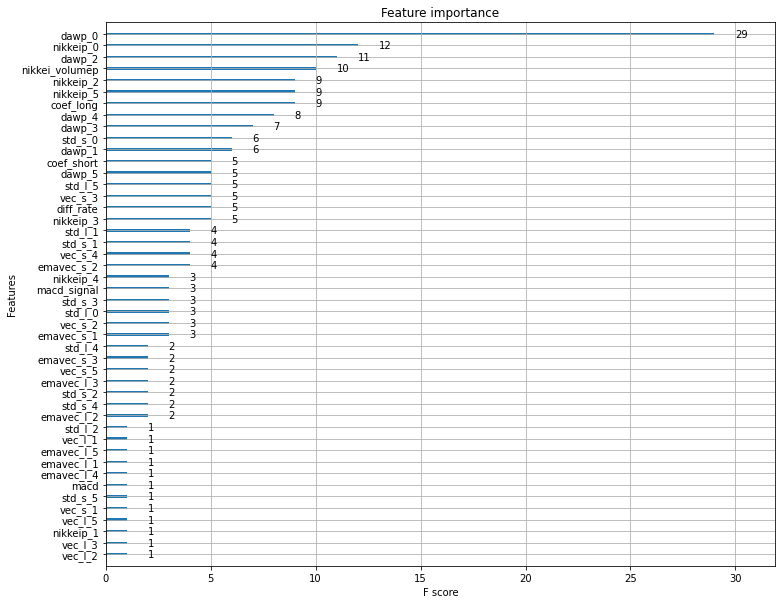

In [33]:
lx = LearnXGB()
lx.learn_xgb(path_tpx,path_daw)

# Strategy maker

In [29]:
sm = StrategyMaker(lx)
sm.learn(path_tpx,path_daw)


In [140]:
sl = XGBSimulation(lx.model,alpha=0.5)
sl.simulate_sm(path_tpx_sim, path_daw_sim, sm, start_year=2021,start_month=1,end_month=12,ma_short=5,ma_long=25,theta=0.0001)

# latest path

In [17]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')

Total profit :180.5
Trade count  :58
Max profit   :123.0
Min profit   :-67.0
Mean profit  :3.1120689655172415
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.616327      0.613793            0.62   0.700787     0.525424   127.0   

   down_num  
0     118.0  



<Figure size 432x288 with 0 Axes>

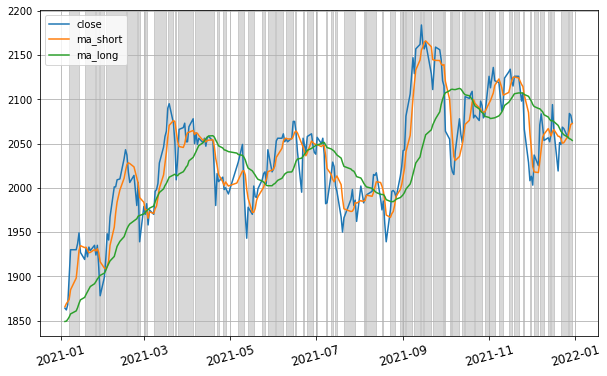

Total profit :-282.0
Trade count  :35
Max profit   :103.0
Min profit   :-86.0
Mean profit  :-8.057142857142857
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.664122       0.62963            0.72   0.784615     0.545455    65.0   

   down_num  
0      66.0  



<Figure size 432x288 with 0 Axes>

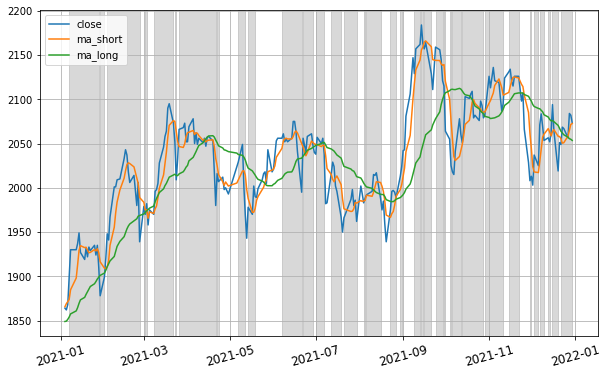

Total profit :-244.0
Trade count  :17
Max profit   :42.0
Min profit   :-106.0
Mean profit  :-14.352941176470589
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.681159      0.666667        0.708333   0.810811      0.53125    37.0   

   down_num  
0      32.0  



<Figure size 432x288 with 0 Axes>

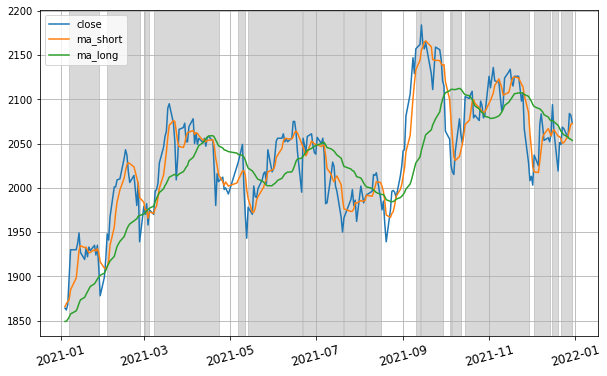

Total profit :-113.0
Trade count  :7
Max profit   :98.0
Min profit   :-106.0
Mean profit  :-16.142857142857142
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.827586           0.8        0.888889   0.941176     0.666667    17.0   

   down_num  
0      12.0  



<Figure size 432x288 with 0 Axes>

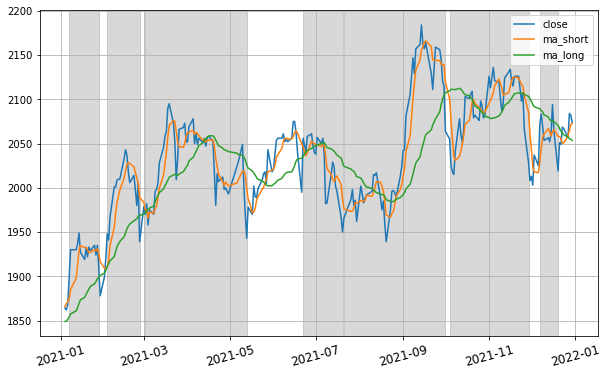

Total profit :-27.0
Trade count  :1
Max profit   :-27.0
Min profit   :-27.0
Mean profit  :-27.0
division by zero
None



<Figure size 432x288 with 0 Axes>

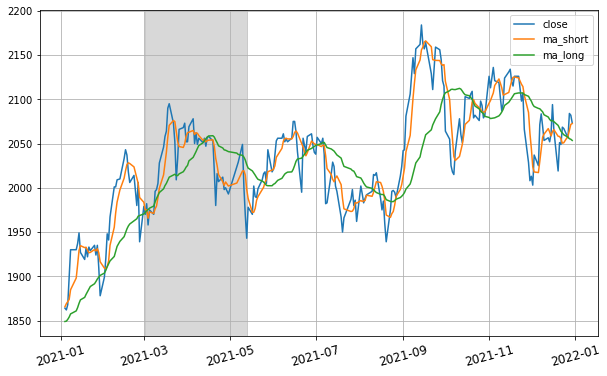

In [20]:
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    sl = XGBSimulation(lx.model,alpha=alpha)
    sl.simulate(path_tpx_sim,path_daw_sim,strategy='normal',start_year=2021,start_month=1,end_month=12)

Total profit :55.0
Trade count  :4
Max profit   :49.0
Min profit   :-32.0
Mean profit  :13.75
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.611111      0.615385             0.6        0.8        0.375    10.0   

   down_num  
0       8.0  



<Figure size 432x288 with 0 Axes>

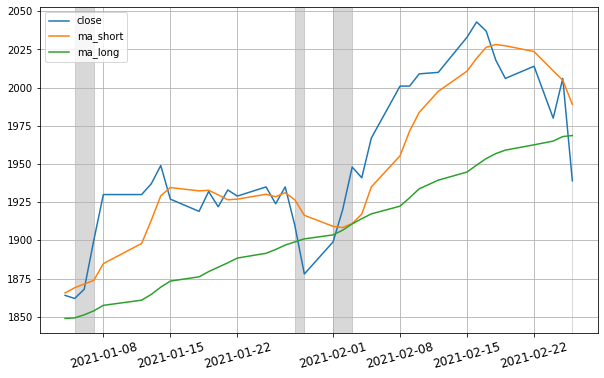

Total profit :55.0
Trade count  :4
Max profit   :57.0
Min profit   :-21.0
Mean profit  :13.75
   score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.625      0.666667             0.5        0.8     0.333333    15.0   

   down_num  
0       9.0  



<Figure size 432x288 with 0 Axes>

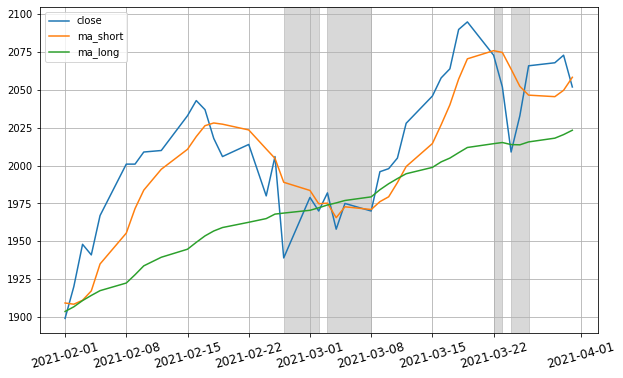

Total profit :46.0
Trade count  :5
Max profit   :57.0
Min profit   :-21.0
Mean profit  :9.2
   score  Up precision  Down precision  Up recall  Down recall  up_num  \
0   0.68      0.684211        0.666667   0.866667          0.4    15.0   

   down_num  
0      10.0  



<Figure size 432x288 with 0 Axes>

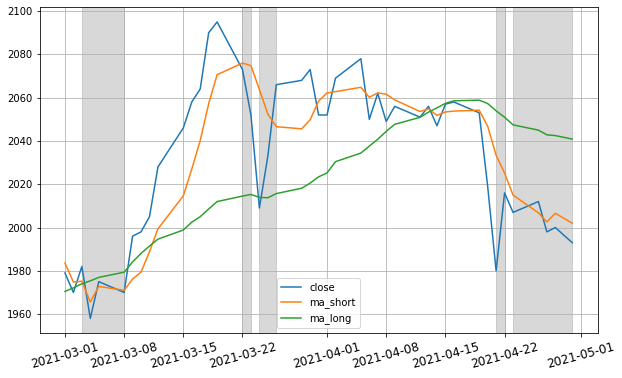

Total profit :95.0
Trade count  :4
Max profit   :36.0
Min profit   :9.0
Mean profit  :23.75
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.722222      0.636364        0.857143      0.875          0.6     8.0   

   down_num  
0      10.0  



<Figure size 432x288 with 0 Axes>

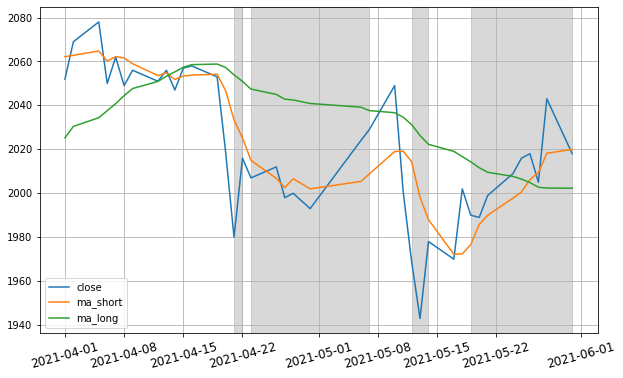

Total profit :128.0
Trade count  :4
Max profit   :66.0
Min profit   :-8.0
Mean profit  :32.0
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.764706      0.666667           0.875   0.857143          0.7     7.0   

   down_num  
0      10.0  



<Figure size 432x288 with 0 Axes>

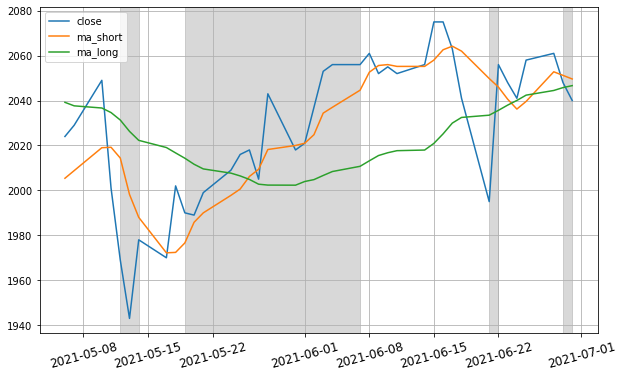

Total profit :28.0
Trade count  :5
Max profit   :61.0
Min profit   :-22.0
Mean profit  :5.6
    score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.8125          0.75           0.875   0.857143     0.777778     7.0   

   down_num  
0       9.0  



<Figure size 432x288 with 0 Axes>

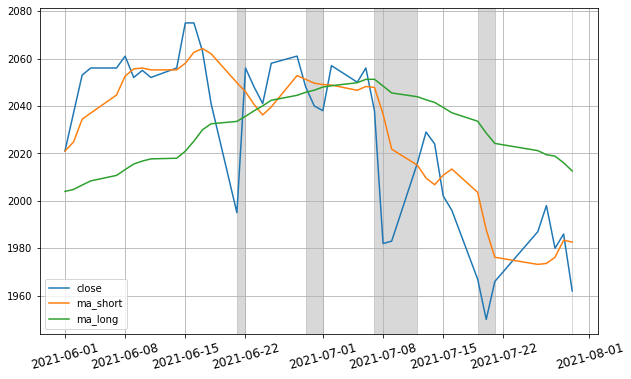

Total profit :13.0
Trade count  :7
Max profit   :24.0
Min profit   :-22.0
Mean profit  :1.8571428571428572
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.714286           0.8        0.636364   0.666667     0.777778    12.0   

   down_num  
0       9.0  



<Figure size 432x288 with 0 Axes>

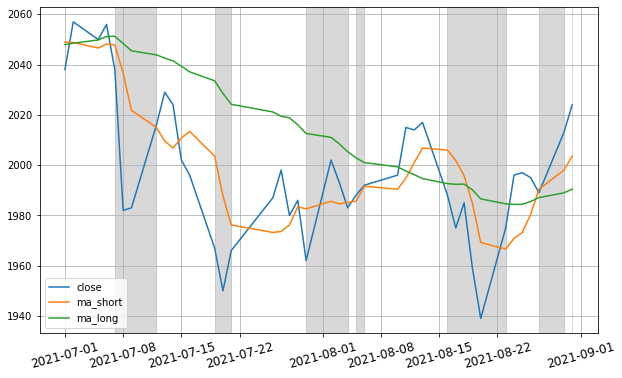

Total profit :160.0
Trade count  :8
Max profit   :105.0
Min profit   :-13.0
Mean profit  :20.0
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.555556      0.533333        0.583333   0.615385          0.5    13.0   

   down_num  
0      14.0  



<Figure size 432x288 with 0 Axes>

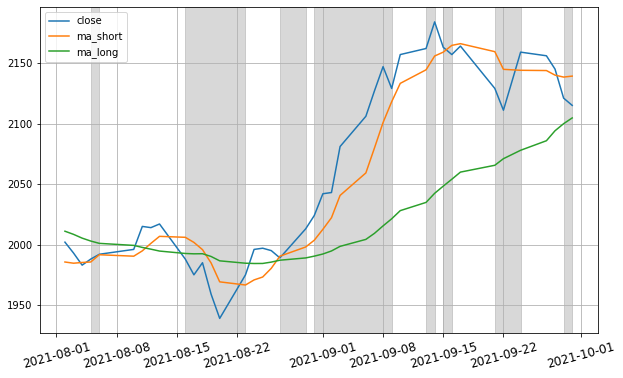

Total profit :0.0
Trade count  :9
Max profit   :30.0
Min profit   :-18.0
Mean profit  :0.0
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.518519      0.388889        0.777778   0.777778     0.388889     9.0   

   down_num  
0      18.0  



<Figure size 432x288 with 0 Axes>

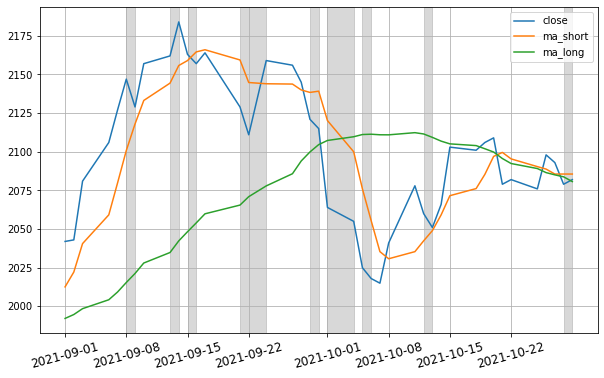

Total profit :-95.0
Trade count  :5
Max profit   :36.0
Min profit   :-118.0
Mean profit  :-19.0
     score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.52381      0.384615            0.75   0.714286     0.428571     7.0   

   down_num  
0      14.0  



<Figure size 432x288 with 0 Axes>

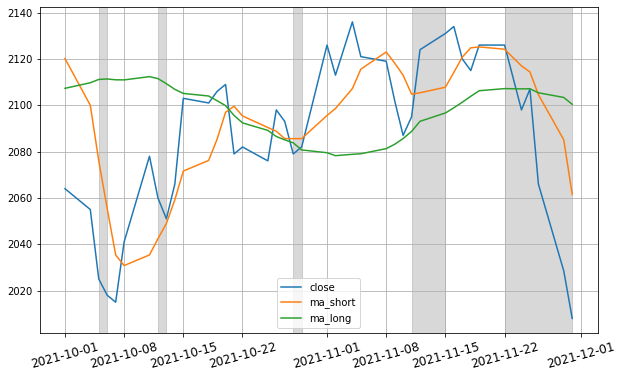

Total profit :63.5
Trade count  :7
Max profit   :46.5
Min profit   :-118.0
Mean profit  :9.071428571428571
     score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.73913          0.75        0.727273       0.75     0.727273    12.0   

   down_num  
0      11.0  



<Figure size 432x288 with 0 Axes>

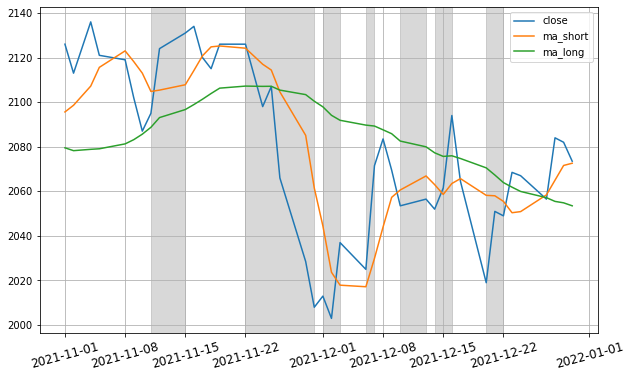

In [35]:
alpha=0.6
for month in range(1,12):
    sl = XGBSimulation(lx.model,alpha=alpha)
    sl.simulate(path_tpx_sim,path_daw_sim,strategy='reverse',start_year=2021,start_month=month,end_month=month+1)

# predict tomorrow

Total profit :-4.0
Trade count  :1
Max profit   :-4.0
Min profit   :-4.0
Mean profit  :-4.0
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.666667           0.5             1.0        1.0          0.5     1.0   

   down_num  
0       2.0  



<Figure size 432x288 with 0 Axes>

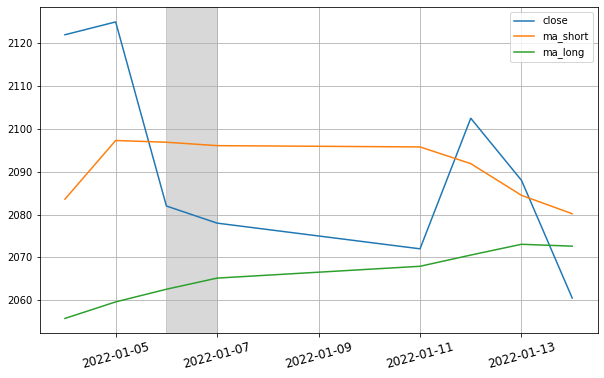

df_con in predict_tomorrow 2022-01-14 00:00:00
today : 2022-01-14 00:00:00
tomorrow UP possibility 0.54470724


In [73]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')

lx.predict_tomorrow(path_tpx_sim,path_daw_sim,alpha=0.6,strategy='reverse',start_year=2022,start_month=1,end_month=1)

# 累積収益率　比較

*************************
alpha : 0.5
*************************
alpha : 0.6
*************************
alpha : 0.7
*************************
alpha : 0.8
*************************
alpha : 0.9


<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

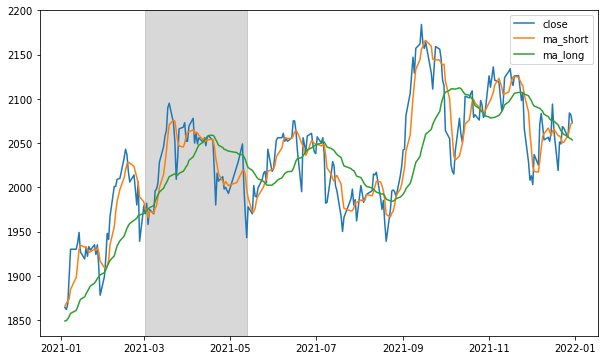

In [49]:
pr_log_xn = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lx.model,alpha=alpha)
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='normal')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xn[alpha] = pr_tmp

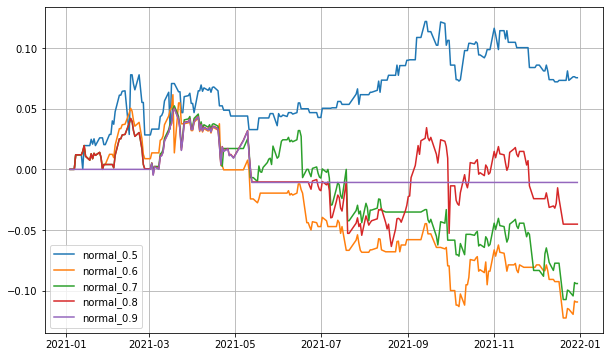

In [50]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.plot(pr_log_xn[0.6]['eval_reward'],label='normal_0.6')
plt.plot(pr_log_xn[0.7]['eval_reward'],label='normal_0.7')
plt.plot(pr_log_xn[0.8]['eval_reward'],label='normal_0.8')
plt.plot(pr_log_xn[0.9]['eval_reward'],label='normal_0.9')
plt.legend()
plt.grid(True)
plt.show()

*************************
alpha : 0.5
*************************
alpha : 0.6
*************************
alpha : 0.7
*************************
alpha : 0.8
*************************
alpha : 0.9


<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

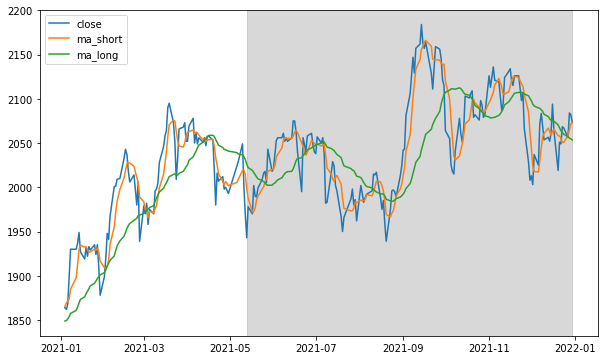

In [51]:
pr_log_xr = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lx.model,alpha=alpha)
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='reverse')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xr[alpha] = pr_tmp

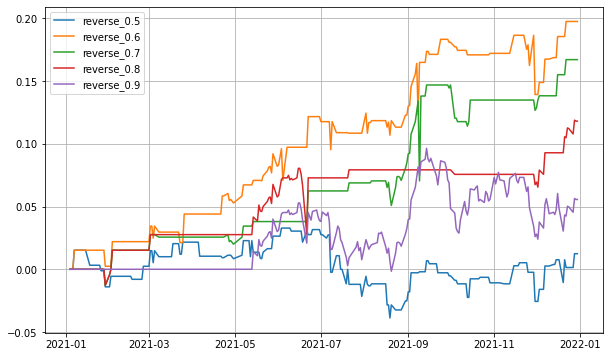

In [52]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xr[0.5]['eval_reward'],label='reverse_0.5')
plt.plot(pr_log_xr[0.6]['eval_reward'],label='reverse_0.6')
plt.plot(pr_log_xr[0.7]['eval_reward'],label='reverse_0.7')
plt.plot(pr_log_xr[0.8]['eval_reward'],label='reverse_0.8')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_tpx['reward'].iloc[:-2],label='TOPIX')
plt.plot(pr_log_t[pr_log_t.index.year==2021]['eval_reward'].iloc[:-2],label='Technical')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.legend()
plt.grid(True)
plt.show()